# Import


In [4]:
# PyTorch
import torch
import torch.nn as nn
from torch.optim import optimizer

# For data preprocess
import numpy as np
import csv
import os

# For plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from roboticstoolbox import DHRobot, RevoluteMDH 
import math

# GPU infomation


In [5]:
GPU_name = torch.cuda.get_device_name()
print(GPU_name)

NVIDIA GeForce RTX 4090


# Utilities

In [6]:
def get_device():
    ''' Get device (if GPU is available, use GPU) '''
    return 'cuda' if torch.cuda.is_available() else 'cpu'

def plot_learning_curve(loss_record, title=''):
    ''' Plot learning curve of your DNN (train & dev loss) '''
    total_steps = len(loss_record['train'])
    x_1 = range(total_steps)
    # x_2 = x_1[::len(loss_record['train']) // len(loss_record['dev'])]
    x_2 = range(total_steps)
    figure(figsize=(6, 4))
    plt.plot(x_1, loss_record['train'], c='tab:red', label='train')
    plt.plot(x_2, loss_record['dev'], c='tab:cyan', label='dev')
    plt.ylim(0.0, 1.)
    plt.xlabel('Training steps')
    plt.ylabel('MSE loss')
    plt.title('Learning curve of {}'.format(title))
    plt.legend()
    plt.show()

# Network


In [7]:
class NeuralNet(nn.Module):
    ''' A neural network '''
    def __init__(self, input_dim, output_dim):
        super(NeuralNet, self).__init__()

        # Define your neural network here
        # TODO: How to modify this model to achieve better performance?
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.Sigmoid(),
            nn.Linear(32, 64),
            nn.RReLU(),
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, output_dim)
        )

        # Mean squared error loss
        self.criterion = nn.MSELoss(reduction='mean')

    def forward(self, x):
        ''' Given input of size (batch_size x input_dim), compute output of the network '''
        return self.net(x)

    def cal_loss(self, pred, target):
        ''' Calculate loss '''
        # def euclidean_distance(y_true, y_pred):
        # return kr.sqrt(kr.sum(kr.square(y_true - y_pred)))
        return self.criterion(pred, target)

# 宣告Dobot位置與軸關節公式函數(順向運動學)


In [8]:
def dobot_forword_kine(joints):

    if joints.ndim == 1:
        joints = np.expand_dims(joints, 0)

    q1 = joints[:, 0:1] # 0:1而非直接0->確保內部採用Column處理
    q2 = joints[:, 1:2]
    q3 = joints[:, 2:3]

    a2 = 135
    a3 = 147
    a4 = 61

    C1 = np.cos(q1)
    C2 = np.cos(q2)
    C23 = np.cos(q2 + q3)
    S1 = np.sin(q1)
    S2 = np.sin(q2)
    S23 = np.sin(q2 + q3)

    dx = C1 * (a3 * C23 + a2 * C2 + a4)
    dy = S1 * (a3 * C23 + a2 * C2 + a4)
    dz = -a2 * S2 - a3 * S23	

    Point = np.hstack([dx, dy, dz]) # 建立陣列
    return Point

# 產生訓練集資料

In [9]:
def gen_data(Train_num):
    joint_1 = (-np.pi / 2) + np.pi * np.random.rand(Train_num, 1)
    joint_2 = (-85 * np.pi / 180) + (85 * np.pi / 180) * np.random.rand(Train_num, 1)
    joint_3 = (-10 * np.pi / 180) + (105 * np.pi / 180) * np.random.rand(Train_num, 1)
    joints = np.hstack((joint_1, joint_2, joint_3))
    points = dobot_forword_kine(joints)
    return points, joints

In [10]:
x_train, y_train = gen_data(10000)
x_dev, y_dev = gen_data(500)

# Dev Func


In [11]:
def dev(feature_dev,target_dev, model, device):
    model.eval()                                # set model to evalutation mode
    with torch.no_grad():                   # disable gradient calculation
        pred = model(feature_dev)                     # forward pass (compute output)
        mse_loss = model.cal_loss(pred, target_dev)  # compute loss
    return mse_loss

# Train Setup

In [12]:
# Ref: https://ithelp.ithome.com.tw/articles/10276281

# 0) prepare data

feature = torch.from_numpy(x_train)
print(feature.size())
target = torch.from_numpy(y_train)
print(target.size())

feature_dev = torch.from_numpy(x_dev)
target_dev = torch.from_numpy(y_dev)

feature,target=feature.type(torch.FloatTensor),target.type(torch.FloatTensor)
feature_dev,target_dev=feature_dev.type(torch.FloatTensor),target_dev.type(torch.FloatTensor)


n_samples, n_features = feature.shape
print(n_samples)
print(n_features)

# 1) model
model = NeuralNet(n_features, n_features)
# 2) loss and optimizer
learning_rate = 0.001
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 3) training loop
epochs = 10000
min_mse = 1000.0
os.makedirs('models', exist_ok=True)
device = get_device()                 # get the current available device ('cpu' or 'cuda')
loss_record = {'train': [], 'dev': []} 

torch.Size([10000, 3])
torch.Size([10000, 3])
10000
3


# Training Loop

In [13]:
for epoch in range(epochs):
    model.train()
    # forward pass and loss
    y_predicted = model(feature)
    # print(y_predicted)
    # loss = criterion(y_predicted, target)
    mse_loss = model.cal_loss(y_predicted, target)

    # backward pass
    mse_loss.backward()


    # update
    optimizer.step()
    loss_record['train'].append(mse_loss.detach().cpu().item())

    dev_mse = dev(feature_dev,target_dev, model, device)
    loss_record['dev'].append(dev_mse)

    # init optimizer
    optimizer.zero_grad()

    if (epoch + 1) % 10 == 0:
        print(f'epoch: {epoch+1}, dev_loss = {dev_mse.item(): .4f}')
        if (dev_mse < min_mse):
            torch.save(model.state_dict(), 'models/model.pth')
            min_mse = dev_mse
            print('Saving model (epoch = {:4d}, train_loss = {:.4f}, dev_loss = {:.4f})'
                    .format(epoch + 1, mse_loss, dev_mse))
            

print('Finished training after {} epochs'.format(epoch+1))

epoch: 10, dev_loss =  0.5424
Saving model (epoch =   10, train_loss = 0.5429, dev_loss = 0.5424)
epoch: 20, dev_loss =  0.3568
Saving model (epoch =   20, train_loss = 0.3498, dev_loss = 0.3568)
epoch: 30, dev_loss =  0.2507
Saving model (epoch =   30, train_loss = 0.2518, dev_loss = 0.2507)
epoch: 40, dev_loss =  0.1722
Saving model (epoch =   40, train_loss = 0.1685, dev_loss = 0.1722)
epoch: 50, dev_loss =  0.1439
Saving model (epoch =   50, train_loss = 0.1408, dev_loss = 0.1439)
epoch: 60, dev_loss =  0.1240
Saving model (epoch =   60, train_loss = 0.1211, dev_loss = 0.1240)
epoch: 70, dev_loss =  0.1144
Saving model (epoch =   70, train_loss = 0.1094, dev_loss = 0.1144)
epoch: 80, dev_loss =  0.1086
Saving model (epoch =   80, train_loss = 0.1040, dev_loss = 0.1086)
epoch: 90, dev_loss =  0.1046
Saving model (epoch =   90, train_loss = 0.1000, dev_loss = 0.1046)
epoch: 100, dev_loss =  0.1018
Saving model (epoch =  100, train_loss = 0.0973, dev_loss = 0.1018)
epoch: 110, dev_los

# Test

In [14]:
# generate test data
# in this problem, the test set is not completely unknown, so I print it out and even calculate the loss
x_test, y_test = gen_data(20)
test_feature = torch.from_numpy(x_test)
test_target = torch.from_numpy(y_test)
test_feature,test_target=test_feature.type(torch.FloatTensor),test_target.type(torch.FloatTensor)
n_samples, n_features = test_feature.shape

In [15]:
del model
model = NeuralNet(n_features, n_features).to(device)
ckpt = torch.load('models/model.pth', map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [16]:
model.eval()   
test_feature = test_feature.to(device) 
test_target = test_target.to(device)                             # set model to evalutation mode
with torch.no_grad():                   # disable gradient calculation
    pred = model(test_feature)                     # forward pass (compute output)
# print("test_feature: ")
# print(test_feature)
print("y_pred: ")
print(pred)
print("y_test: ")
print(test_target)
print("test MSE loss: ")
test_loss = model.cal_loss(pred, test_target)
print(test_loss)

y_pred: 
tensor([[ 1.1021, -0.7718,  0.1922],
        [-1.2757, -0.2033,  0.6773],
        [ 0.3276, -1.1028,  0.1752],
        [-0.0795, -0.7841,  1.0956],
        [ 0.2495, -0.6925,  1.3186],
        [ 0.8539, -0.0747,  1.3080],
        [-0.5006, -1.3685,  1.6894],
        [ 1.0175, -1.4007,  0.7015],
        [-0.6896, -0.1377,  0.1915],
        [-0.1786, -0.5474,  0.2046],
        [ 1.5404, -0.0146,  0.2690],
        [ 0.8975, -0.0731,  0.8508],
        [ 0.5911, -1.0351,  0.9964],
        [ 0.4391, -0.2024,  0.2970],
        [ 1.0838, -0.0997,  0.7971],
        [ 0.7721, -1.0606,  1.0419],
        [ 0.9076, -1.0742,  0.2213],
        [-0.6602, -0.5430,  0.5032],
        [ 1.5307, -1.4387,  0.8098],
        [ 0.2272, -0.7751,  0.1912]], device='cuda:0')
y_test: 
tensor([[ 1.1179, -0.8195,  0.3079],
        [-1.2754, -0.1443,  0.5331],
        [ 0.3068, -0.9944, -0.0486],
        [-0.0855, -0.7764,  1.1161],
        [ 0.2359, -0.6864,  1.3012],
        [ 0.8254, -0.0680,  1.2470],
  

# Visualization

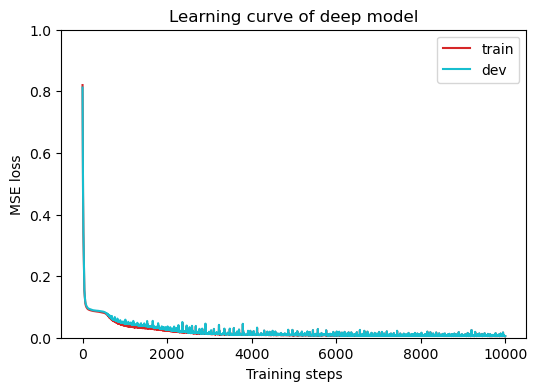

In [17]:
plot_learning_curve(loss_record, title='deep model')
# the learning curve of dev and train overlaps since this problem is simple

# Robot Arm

In [19]:
arr = pred[1].cpu().detach().numpy()
if(abs(arr[2])>abs(arr[1])):
    t4 = np.sign(arr[1]) * (abs(arr[2])-abs(arr[1]))
else:
    t4 =  np.sign(arr[2]) * (abs(arr[1])-abs(arr[2]))

print('pred')
print(arr)
print('')

print('target')
print(test_target[1])
print('')

arr = np.append(arr, np.array([t4,0]), axis=0)

print('joint config')
print(arr)
print('')

pred
[-1.275746  -0.2033295  0.6773192]

target
tensor([-1.2754, -0.1443,  0.5331], device='cuda:0')

joint config
[-1.27574599 -0.2033295   0.67731923 -0.47398973  0.        ]

